In [31]:
import os
path = os.getcwd()

In [35]:
import sys
import os
import logging

from pathlib import Path
from logging.handlers import RotatingFileHandler
from src.config.settings import settings

from src.config.settings import settings

logger = logging.getLogger(name)
 
if logging.handlers:
    print("oh YES")

logger.setLevel(settings.log_level)




<Logger s (WARNING)>

In [33]:
os.path.dirname(path)

'd:\\Travel_Planner'

In [22]:
import os
import sys

src_path = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), "src")
parent_path = os.path.dirname(os.path.abspath(os.getcwd()))
print(src_path)
sys.path.append(src_path)
sys.path.append(parent_path)

d:\Travel_Planner\src


In [23]:
import os
from typing import Literal, List, Optional
from datetime import datetime

# LangChain / LangGraph Imports
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display

from src.agents.destination_info_agent import DestinationInfoAgent
from src.agents.final_trip_planner_agent import FinalTripPlanner
from src.agents.info_gather_agent import InformationGatherChatbot
from src.agents.flight_search_agent import FlightSpecialistAgent

from src.tools.attraction_finding_tool import attraction_finding_tool
from src.tools.hotel_tool import hotel_finding_tool
from src.tools.restaurant_tool import restaurant_finding_tool
from src.tools.flight_search_tool import One_way_flight_search
from src.tools.web_search_tool import web_search_tool
from src.tools.distance_measurement_tool import distance_measurement_tool
from src.tools.time_gather_tool import time_tool

from src.utils.helping_class.conversation_format import ConversationFormat
from src.utils.http.custom_states import CustomState

from src.prompts.final_trip_planner_prompts import main_agent_system_prompt
from src.config.settings import settings

In [24]:
import os 
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

In [25]:
model = ChatGoogleGenerativeAI(model=settings.flash_model, temperature=0, api_key = settings.google_api_key)
trip_advisor_agent = DestinationInfoAgent(model, [attraction_finding_tool, hotel_finding_tool, restaurant_finding_tool])
flight_agent = FlightSpecialistAgent(model, [One_way_flight_search])

In [5]:
prompt = f"I'm going to Islamabad and karachi for 3 days. Find hotels/restaurants/attraction."
result = trip_advisor_agent.invoke({"messages": [{"role": "user", "content": prompt}]})

The raw result is: {'search_metadata': {'id': '696b30be6f1e405a43d160b7', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/c6229c774e1df7e2/696b30be6f1e405a43d160b7.json', 'created_at': '2026-01-17 06:48:30 UTC', 'processed_at': '2026-01-17 06:48:30 UTC', 'tripadvisor_url': 'https://www.tripadvisor.com/Search?q=Islamabad&ssrc=h&geo=1&offset=0&limit=30', 'raw_html_file': 'https://serpapi.com/searches/c6229c774e1df7e2/696b30be6f1e405a43d160b7.html', 'prettify_html_file': 'https://serpapi.com/searches/c6229c774e1df7e2/696b30be6f1e405a43d160b7.prettify', 'total_time_taken': 0.5}, 'search_parameters': {'engine': 'tripadvisor', 'q': 'Islamabad', 'tripadvisor_domain': 'www.tripadvisor.com', 'ssrc': 'h', 'offset': 0, 'limit': 30}, 'places': [{'position': 1, 'title': 'Islamabad Serena Hotel', 'place_type': 'ACCOMMODATION', 'place_id': '302556', 'link': 'https://www.tripadvisor.com/Hotel_Review-g293960-d302556-Reviews-Islamabad_Serena_Hotel-Islamabad_Islamabad_Capital_Territor

In [26]:
prompt = f"Find one-way flights from Beijing to [Islamabad, Lahore] on 26 January 2026"
result = flight_agent.invoke({"messages": [{"role": "user", "content": prompt}]})

In [28]:
print(result.get("messages")[-1].content[0]['text'])

Here are the one-way flight options from Beijing to Islamabad and Lahore on January 26, 2026:

**Flights from Beijing (PEK) to Islamabad (ISB) on 2026-01-26**

*   **Lowest Available Price:** $1230 (Current price status: high)

*   **Best Flight Options:**
    *   **Flight Option 1:** Price: $1331, Total Flight Duration: 22.2 hours, Layovers: Hong Kong International Airport, Dubai International Airport
    *   **Flight Option 2:** Price: $1474, Total Flight Duration: 27.8 hours, Layovers: Dubai International Airport
    *   **Flight Option 3:** Price: $1540, Total Flight Duration: 20.2 hours, Layovers: Dubai International Airport, Jinnah International Airport

*   **Other Options (Cheaper but Longer Duration):**
    *   **Flight Option 1 & 2:** Price: $1230, Total Flight Duration: 52.5 hours, Layovers: Taiwan Taoyuan International Airport, Suvarnabhumi Airport

**Flights from Beijing (PEK) to Lahore (LHE) on 2026-01-26**

*   **Lowest Available Price:** $450 (Current price status: typi

In [4]:
os.environ["GOOGLE_API_KEY"] = settings.google_api_key
class TravelAutomationSystem:
    def __init__(self):
        """
        Initialize the system ONCE.
        This sets up the shared model, tools, and the graph definition.
        """
        # 1. Shared Resources
        self.checkpointer = InMemorySaver() # In production, swap this for PostgresSaver/SqliteSaver
        self.model = ChatGoogleGenerativeAI(model=settings.flash_model, temperature=0, api_key = settings.google_api_key)
        
        # 2. Initialize Sub-Agents (Shared Instances)
        self.info_gather_agent = InformationGatherChatbot(self.model, ConversationFormat, [time_tool])
        self.flight_agent = FlightSpecialistAgent(self.model, [One_way_flight_search])
        self.trip_advisor_agent = DestinationInfoAgent(self.model, [attraction_finding_tool, hotel_finding_tool, restaurant_finding_tool])
        self.travel_partner = FinalTripPlanner(self.model, [web_search_tool, distance_measurement_tool], main_agent_system_prompt)

        # 3. Build the Graph
        self.app = self._build_workflow()

    def _build_workflow(self):
        """
        Constructs the LangGraph workflow.
        """
        workflow = StateGraph(CustomState)
        
        # Register Nodes (pointing to class methods)
        workflow.add_node("gather_info_node", self.gather_info_node)
        workflow.add_node("search_flights", self.flight_node)
        workflow.add_node("search_hotels", self.accommodation_node)
        workflow.add_node("compile_itinerary", self.itinerary_compiler_node)

        # Register Edges & Conditions
        workflow.add_conditional_edges(
            START, 
            self.node_switch_condition, 
            {"gather_info_node": "gather_info_node", "travel_partner_node": "compile_itinerary"}
        )
        
        workflow.add_conditional_edges(
            "gather_info_node", 
            self.conditional_move, 
            ["search_flights", "search_hotels", END]
        )
        
        workflow.add_edge("search_flights", "compile_itinerary")
        workflow.add_edge("search_hotels", "compile_itinerary")
        workflow.add_edge("compile_itinerary", END)
        
        # Compile with the shared checkpointer
        return workflow.compile(checkpointer=self.checkpointer)
    def show_graph(self):
        display(Image(self.app.get_graph().draw_mermaid_png()))
    # --- NODE IMPLEMENTATIONS ---

    def gather_info_node(self, state: CustomState):
        print("--- Gathering Info Node ---")
        
        # 1. Get User Input
        messages = state.get("messages", [])
        if not messages:
            return {"messages": [AIMessage(content="Error: No messages found.")]}
        
        last_message = messages[-1]
        user_input = last_message.content if hasattr(last_message, 'content') else last_message['content']

        # 2. Identify what is CURRENTLY missing
        required_fields = ["Departure", "Destination", "StartDate", "Duration", "Budget", "Interest", "ExtraDetail"]
        current_missing = []
        
        for field in required_fields:
            val = state.get(field)
            if val is None or val in ["None", "Null", "null"] or (isinstance(val, list) and (len(val) == 0 or val == ['None'])):
                current_missing.append(field)
                
        print(f"Missing before this turn: {current_missing}")

        # 3. Call Chatbot
        extracted_data = self.info_gather_agent.ask(user_input, missing_list=current_missing)
        
        # 4. MERGE LOGIC (FIXED)
        final_updates = {}
        
        for field in required_fields:
            new_val = extracted_data.get(field)
            old_val = state.get(field)
            
            # --- ROBUST EMPTY CHECK ---
            # We treat it as empty if:
            # 1. It is None
            # 2. It is a string "None", "Null", etc.
            # 3. It is an empty list []
            # 4. It is a list containing only "None" -> ['None'] (THIS WAS THE BUG)
            is_new_empty = False
            
            if new_val is None:
                is_new_empty = True
            elif isinstance(new_val, str) and new_val.lower() in ["none", "null", ""]:
                is_new_empty = True
            elif isinstance(new_val, list):
                if len(new_val) == 0:
                    is_new_empty = True
                # Check if the list contains only "None" strings
                elif all(str(x).lower() in ["none", "null"] for x in new_val):
                    is_new_empty = True
            
            print(f"Field: {field}, New: {new_val}, Old: {old_val}, Is New Empty? {is_new_empty}")

            if not is_new_empty:
                # New value is valid, update it
                final_updates[field] = new_val
            else:
                # New value is empty, KEEP OLD VALUE
                final_updates[field] = old_val
                
        # 5. Re-Check Completion
        is_complete = True
        for field in required_fields:
            val = final_updates.get(field)
            
            # Perform the same strict check for the final state
            is_val_empty = False
            if val is None:
                is_val_empty = True
            elif isinstance(val, str) and val.lower() in ["none", "null", ""]:
                is_val_empty = True
            elif isinstance(val, list):
                if len(val) == 0 or all(str(x).lower() in ["none", "null"] for x in val):
                    is_val_empty = True
            
            if is_val_empty:
                is_complete = False
                break

        return {
            "Departure": final_updates["Departure"],
            "Destination": final_updates["Destination"],
            "StartDate": final_updates["StartDate"],
            "Duration": final_updates["Duration"],
            "Budget": final_updates["Budget"],
            "Interest": final_updates["Interest"],
            "ExtraDetail": final_updates["ExtraDetail"],
            "AllDetails": is_complete,
            "messages": [AIMessage(content=extracted_data["Response"])]
        }

    def flight_node(self, state: CustomState):
        if not state.get('Departure') or not state.get('Destination'):
            return {"flight_info": "Flight details skipped due to missing info."}
        
        dest = state['Destination'][0] if isinstance(state['Destination'], list) else state['Destination']
        prompt = f"Find one-way flights from {state['Departure']} to {dest} on {state['StartDate']}"
        
        print(f"--- Flight Node (Running) for {dest} ---")
        result = self.flight_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
        flight_content = result['messages'][-1].content
        print("Flight Info Captured.") 
        return {"flight_info": flight_content}

    def accommodation_node(self, state: CustomState):
        print("--- Hotel, Restaurant and Attraction Node (Running) ---")
        prompt = f"I'm going to {state.get('Destination')} for {state.get('Duration')} days. Find hotels/restaurants. Summarize best options."
        result = self.trip_advisor_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
        hotel_content = result['messages'][-1].content
        print("Accommodation Info Captured.")
        return {"hotel_info": hotel_content}

    def itinerary_compiler_node(self, state: CustomState):
        # 1. Prepare Prompt based on mode
        if state.get("TravelMode") == "Travel_Plan":
            prompt = f"""
            I want to go to {state['Destination']} from {state['Departure']} for {state['Duration']}. 
            Start: {state['StartDate']}. Interests: {state['Interest']}. Budget: {state['Budget']} 
            Extra: {state['ExtraDetail']}
            
            DATA SOURCE 1 (Flights): {state.get('flight_info')}
            DATA SOURCE 2 (Hotels): {state.get('hotel_info')}
            
            Task: Combine this into a final formatted itinerary report.
            """
        else:
            # Revision Logic
            last_message = state['messages'][-1]
            user_input = last_message.content if hasattr(last_message, 'content') else last_message['content']
            prompt = f"""
            Fix the plan based on this concern: {user_input}
            Previous Plan: {state.get("previous_plan")}
            """

        print("--- Streaming Final Itinerary ---")
        
        # 2. Invoke Final Planner
        # We pass task_mode here just in case your middleware needs it
        input_payload = {
            "messages": [{"role": "user", "content": prompt}],
            "task_mode": state.get("TravelMode", "Travel_Plan")
        }
        
        result = self.travel_partner.invoke(input_payload)
        
        # Handle response format (Agent return vs Chain return)
        if isinstance(result, dict) and 'messages' in result:
             full_response = result['messages'][-1].content
             if isinstance(full_response, list): # Safety for some gemini outputs
                 full_response = full_response[0]['text']
        else:
            full_response = str(result)

        return {
            "messages": [AIMessage(content=full_response)], 
            "previous_plan": full_response
        }

    # --- CONDITIONAL LOGIC ---

    def conditional_move(self, state: CustomState):
        if state.get("AllDetails") is True:
            # We return a dict key update to be safe, though usually node return handles this
            # Note: conditional edges usually just return the string node name.
            # If you need to update state, do it in the node before this edge.
            return ["search_flights", "search_hotels"]
        return END

    def node_switch_condition(self, state: CustomState):
        # Logic: If we have a previous plan and want to revise, go to partner.
        # Or if we just finished gathering info (AllDetails=True), we might want to go there.
        # Adjust logic as per your exact requirement.
        if state.get("move_to_info_chatbot") is True or state.get("TravelMode") == "Revision_Plan":
             return "travel_partner_node"
        return "gather_info_node"

    # --- PUBLIC API ---

    def run_trip_planner(self, user_id: str, user_input: str, mode: str = "Travel_Plan"):
        """
        The main entry point for your API or UI.
        """
        config = {"configurable": {"thread_id": user_id}}
        
        initial_state = {
            "messages": [{"role": "user", "content": user_input}],
            "TravelMode": mode
        }
        
        # Run the graph
        final_state = self.app.invoke(initial_state, config=config)
        
        # Return the last message
        return final_state['messages'][-1].content


In [5]:
system = TravelAutomationSystem()

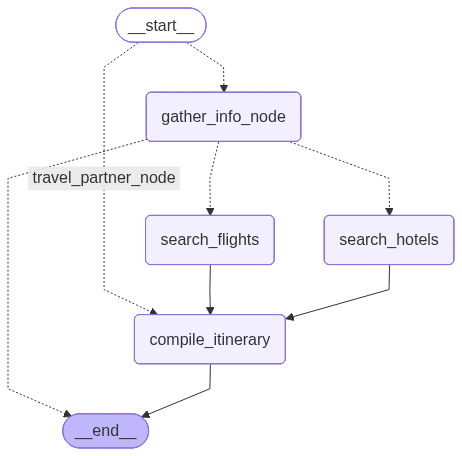

In [6]:
system.show_graph()

In [7]:
inputs = "Hello"

ans = system.run_trip_planner("abc", inputs)
print(ans)

--- Gathering Info Node ---
Missing before this turn: ['Departure', 'Destination', 'StartDate', 'Duration', 'Budget', 'Interest', 'ExtraDetail']
 User Input: Hello,  Remaining Information: ['Departure', 'Destination', 'StartDate', 'Duration', 'Budget', 'Interest', 'ExtraDetail'] 
Field: Departure, New: None, Old: None, Is New Empty? True
Field: Destination, New: [], Old: None, Is New Empty? True
Field: StartDate, New: None, Old: None, Is New Empty? True
Field: Duration, New: None, Old: None, Is New Empty? True
Field: Budget, New: None, Old: None, Is New Empty? True
Field: Interest, New: [], Old: None, Is New Empty? True
Field: ExtraDetail, New: [], Old: None, Is New Empty? True
Hello! I'm your travel planning assistant. To help you plan your perfect trip, I need a little more information. Could you please tell me your departure location, destination, start date, duration, budget, and any specific interests or extra details you have in mind?


In [10]:
inputs = "I want to go to Pakistan"
ans = system.run_trip_planner("abc", inputs)
print(ans)

--- Gathering Info Node ---
Missing before this turn: ['Departure', 'StartDate', 'Duration', 'Budget', 'Interest', 'ExtraDetail']
 User Input: I want to go to Pakistan,  Remaining Information: ['Departure', 'StartDate', 'Duration', 'Budget', 'Interest', 'ExtraDetail'] 
Field: Departure, New: None, Old: None, Is New Empty? True
Field: Destination, New: [], Old: ['Paris', 'Rome', 'Tokyo'], Is New Empty? True
Field: StartDate, New: None, Old: None, Is New Empty? True
Field: Duration, New: None, Old: None, Is New Empty? True
Field: Budget, New: None, Old: None, Is New Empty? True
Field: Interest, New: None, Old: None, Is New Empty? True
Field: ExtraDetail, New: None, Old: None, Is New Empty? True
Pakistan is a beautiful country! To help me plan your trip, could you please tell me which city in Pakistan you'd like to visit? Some popular cities include Karachi, Lahore, and Islamabad.


In [11]:
inputs = "I want to go to Karachi, Lahore, and Islamabad"
ans = system.run_trip_planner("abc", inputs)
print(ans)

--- Gathering Info Node ---
Missing before this turn: ['Departure', 'StartDate', 'Duration', 'Budget', 'Interest', 'ExtraDetail']
 User Input: I want to go to Karachi, Lahore, and Islamabad,  Remaining Information: ['Departure', 'StartDate', 'Duration', 'Budget', 'Interest', 'ExtraDetail'] 
Field: Departure, New: None, Old: None, Is New Empty? True
Field: Destination, New: ['Karachi', 'Lahore', 'Islamabad'], Old: ['Paris', 'Rome', 'Tokyo'], Is New Empty? False
Field: StartDate, New: None, Old: None, Is New Empty? True
Field: Duration, New: None, Old: None, Is New Empty? True
Field: Budget, New: None, Old: None, Is New Empty? True
Field: Interest, New: None, Old: None, Is New Empty? True
Field: ExtraDetail, New: None, Old: None, Is New Empty? True
Great! To help me plan your trip to Karachi, Lahore, and Islamabad, could you please tell me your departure city, your desired start date, how long you plan to stay, your budget, and what your interests are for this trip?


In [12]:
inputs = "I want to go from Taiyuan"
ans = system.run_trip_planner("abc", inputs)
print(ans)

--- Gathering Info Node ---
Missing before this turn: ['Departure', 'StartDate', 'Duration', 'Budget', 'Interest', 'ExtraDetail']
 User Input: I want to go from Taiyuan,  Remaining Information: ['Departure', 'StartDate', 'Duration', 'Budget', 'Interest', 'ExtraDetail'] 
Field: Departure, New: Taiyuan, Old: None, Is New Empty? False
Field: Destination, New: None, Old: ['Karachi', 'Lahore', 'Islamabad'], Is New Empty? True
Field: StartDate, New: None, Old: None, Is New Empty? True
Field: Duration, New: None, Old: None, Is New Empty? True
Field: Budget, New: None, Old: None, Is New Empty? True
Field: Interest, New: None, Old: None, Is New Empty? True
Field: ExtraDetail, New: None, Old: None, Is New Empty? True
Great! To help me plan your trip, could you please tell me your destination, start date, duration, budget, and any specific interests you have for your trip?


In [13]:
inputs = "I want to go next week from now for 2 days"
ans = system.run_trip_planner("abc", inputs)
print(ans)

--- Gathering Info Node ---
Missing before this turn: ['StartDate', 'Duration', 'Budget', 'Interest', 'ExtraDetail']
 User Input: I want to go next week from now for 2 days,  Remaining Information: ['StartDate', 'Duration', 'Budget', 'Interest', 'ExtraDetail'] 
Field: Departure, New: None, Old: Taiyuan, Is New Empty? True
Field: Destination, New: None, Old: ['Karachi', 'Lahore', 'Islamabad'], Is New Empty? True
Field: StartDate, New: 2026-01-24, Old: None, Is New Empty? False
Field: Duration, New: 2 days, Old: None, Is New Empty? False
Field: Budget, New: None, Old: None, Is New Empty? True
Field: Interest, New: None, Old: None, Is New Empty? True
Field: ExtraDetail, New: None, Old: None, Is New Empty? True
Great! So you're looking to start your 2-day trip on January 24, 2026. To help me plan your perfect getaway, could you please tell me where you'd like to depart from, your desired destination, your budget, and any specific interests or extra details you have in mind?


In [14]:
inputs = "2000 dollar"
ans = system.run_trip_planner("abc", inputs)
print(ans)

--- Gathering Info Node ---
Missing before this turn: ['Budget', 'Interest', 'ExtraDetail']
 User Input: 2000 dollar,  Remaining Information: ['Budget', 'Interest', 'ExtraDetail'] 
Field: Departure, New: None, Old: Taiyuan, Is New Empty? True
Field: Destination, New: None, Old: ['Karachi', 'Lahore', 'Islamabad'], Is New Empty? True
Field: StartDate, New: None, Old: 2026-01-24, Is New Empty? True
Field: Duration, New: None, Old: 2 days, Is New Empty? True
Field: Budget, New: 2000 dollar, Old: None, Is New Empty? False
Field: Interest, New: ['None'], Old: None, Is New Empty? True
Field: ExtraDetail, New: ['None'], Old: None, Is New Empty? True
Thank you for providing your budget! To help me plan your trip, could you please tell me about your interests and any extra details you'd like to share?


In [15]:
inputs = "Biking partyinng"
ans = system.run_trip_planner("abc", inputs)
print(ans)

--- Gathering Info Node ---
Missing before this turn: ['Interest', 'ExtraDetail']
 User Input: Biking partyinng,  Remaining Information: ['Interest', 'ExtraDetail'] 
Field: Departure, New: None, Old: Taiyuan, Is New Empty? True
Field: Destination, New: None, Old: ['Karachi', 'Lahore', 'Islamabad'], Is New Empty? True
Field: StartDate, New: None, Old: 2026-01-24, Is New Empty? True
Field: Duration, New: None, Old: 2 days, Is New Empty? True
Field: Budget, New: None, Old: 2000 dollar, Is New Empty? True
Field: Interest, New: ['Biking', 'Party'], Old: None, Is New Empty? False
Field: ExtraDetail, New: None, Old: None, Is New Empty? True
Great! Biking and partying sound like a fun combination. Do you have any extra details or specific preferences for your trip?


In [16]:
inputs = "I want halal food"
ans = system.run_trip_planner("abc", inputs)
print(ans)

--- Gathering Info Node ---
Missing before this turn: ['ExtraDetail']
 User Input: I want halal food,  Remaining Information: ['ExtraDetail'] 
Field: Departure, New: None, Old: Taiyuan, Is New Empty? True
Field: Destination, New: None, Old: ['Karachi', 'Lahore', 'Islamabad'], Is New Empty? True
Field: StartDate, New: None, Old: 2026-01-24, Is New Empty? True
Field: Duration, New: None, Old: 2 days, Is New Empty? True
Field: Budget, New: None, Old: 2000 dollar, Is New Empty? True
Field: Interest, New: ['halal food'], Old: ['Biking', 'Party'], Is New Empty? False
Field: ExtraDetail, New: ['None'], Old: None, Is New Empty? True
Got it! You're looking for halal food options. What other extra details would you like to add?


In [17]:
inputs = "I want halal food that's extra detail"
ans = system.run_trip_planner("abc", inputs)
print(ans)

--- Gathering Info Node ---
Missing before this turn: ['ExtraDetail']
 User Input: I want halal food that's extra detail,  Remaining Information: ['ExtraDetail'] 
Field: Departure, New: None, Old: Taiyuan, Is New Empty? True
Field: Destination, New: None, Old: ['Karachi', 'Lahore', 'Islamabad'], Is New Empty? True
Field: StartDate, New: None, Old: 2026-01-24, Is New Empty? True
Field: Duration, New: None, Old: 2 days, Is New Empty? True
Field: Budget, New: None, Old: 2000 dollar, Is New Empty? True
Field: Interest, New: None, Old: ['halal food'], Is New Empty? True
Field: ExtraDetail, New: ['halal food'], Old: None, Is New Empty? False
--- Flight Node (Running) for Karachi ---
--- Hotel, Restaurant and Attraction Node (Running) ---
The raw result is: {'search_metadata': {'id': '696b30be6f1e405a43d160b7', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/c6229c774e1df7e2/696b30be6f1e405a43d160b7.json', 'created_at': '2026-01-17 06:48:30 UTC', 'processed_at': '2026-01-1